In [79]:
# Basic Imports
import numpy as np
import pandas as pd
import math

# Plotting
import pygal
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

# sklearn
#import intertools
from sklearn import preprocessing
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, normalize

# sklearn KNN
from sklearn.neighbors import KNeighborsClassifier

# sklearn LogisticRegression and GridSearchCV
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import GridSearchCV  # model used to test for the best combination of hyperparameters

# sklearn decision tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

# sklearn random forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# sklearn SVM
from sklearn import svm
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC, LinearSVC
import itertools    #confusion matrix

# sklearn clustering
from sklearn.cluster import AgglomerativeClustering, KMeans

# scipy
from scipy import stats
import scipy.cluster.hierarchy as shc

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# messy dataset
df = pd.read_csv('blood_data.csv')
df.head()

,"Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),""whether he/she donated blood in March 2007"""
0,"2 ,50,12500,98 ,1"
1,"0 ,13,3250,28 ,1"
2,"1 ,16,4000,35 ,1"
3,"2 ,20,5000,45 ,1"
4,"1 ,24,6000,77 ,0"


## Features information

---

_Recency_ $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ - Last donation (months)

_Frequency_ $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ - Total number times of donation

_Monetary_ $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ - Total volume of blood donated (c.c.)

_Time_ $\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;$ - First donation (months)

_"Whether he/she donated blood in March 2007"_ $\;\;\;\;\;\;\;\;$ - Binary data (1: donated, 0: without donate)

In [3]:
# Rename the feature
df = df.rename(columns = {'Recency (months),Frequency (times),Monetary (c.c. blood),Time (months),"whether he/she donated blood in March 2007"'
                          :'messy'})
df.head()

,messy
0,"2 ,50,12500,98 ,1"
1,"0 ,13,3250,28 ,1"
2,"1 ,16,4000,35 ,1"
3,"2 ,20,5000,45 ,1"
4,"1 ,24,6000,77 ,0"


In [4]:
#split dot into 5 columns

def split_dot():
    
    t = df['messy'].str.split(",", n = 4, expand = True).astype(int)
    
    #re-assign column
    df['last_donate'] = t[0]
    df['frequency'] = t[1]
    df['blood_cc'] = t[2]
    df['first_donate'] = t[3]
    df['donate'] = t[4]
        
    return df.head(10)

split_dot()

,messy,last_donate,frequency,blood_cc,first_donate,donate
0,"2 ,50,12500,98 ,1",2,50,12500,98,1
1,"0 ,13,3250,28 ,1",0,13,3250,28,1
2,"1 ,16,4000,35 ,1",1,16,4000,35,1
3,"2 ,20,5000,45 ,1",2,20,5000,45,1
4,"1 ,24,6000,77 ,0",1,24,6000,77,0
5,"4 ,4,1000,4 ,0",4,4,1000,4,0
6,"2 ,7,1750,14 ,1",2,7,1750,14,1
7,"1 ,12,3000,35 ,0",1,12,3000,35,0
8,"2 ,9,2250,22 ,1",2,9,2250,22,1
9,"5 ,46,11500,98 ,1",5,46,11500,98,1


In [5]:
# Drop messy column
df = df.drop(['messy'],axis=1)
df.head()

,last_donate,frequency,blood_cc,first_donate,donate
0,2,50,12500,98,1
1,0,13,3250,28,1
2,1,16,4000,35,1
3,2,20,5000,45,1
4,1,24,6000,77,0


In [6]:
# Count the rate of donating per month
def rate():

    df['rate'] = (df['first_donate'] - df['last_donate']) / df['frequency']
    rate_first = len(df[(df['rate'] > 0)])
    rate_regular = len(df[(df['rate'] == 0)])
    return df

df = rate()
df.head()

,last_donate,frequency,blood_cc,first_donate,donate,rate
0,2,50,12500,98,1,1.920000
1,0,13,3250,28,1,2.153846
2,1,16,4000,35,1,2.125000
3,2,20,5000,45,1,2.150000
4,1,24,6000,77,0,3.166667


In [7]:
def rate_status():
    
    df_cat = df.copy()
    df_cat['rate_status'] = "First_timer"
    df_cat['rate_status'] = np.where(df_cat['rate'] > 0, 'Regular', df_cat['rate_status'])
    return df_cat

df_cat = rate_status()
df_cat.head()

,last_donate,frequency,blood_cc,first_donate,donate,rate,rate_status
0,2,50,12500,98,1,1.920000,Regular
1,0,13,3250,28,1,2.153846,Regular
2,1,16,4000,35,1,2.125000,Regular
3,2,20,5000,45,1,2.150000,Regular
4,1,24,6000,77,0,3.166667,Regular


In [8]:
def catogories_label():
    
    row, col = df_cat.shape

    #create columns
    df_cat['last_donate_group']=''
    df_cat['frequency_lvl']=''
    df_cat['blood_volumn']=''
    df_cat['state_of_first_donate']=''
    
    # Define Categories
    for i in range(row):
        for k in range(col):
            
            # last_donate
            # 0-14: group 1, 15-29: group 2, 30-44: group 3, 45-59: group 4, 60-74: group 5. 
            if k == 0:
                if df_cat.iloc[i,k] >= 0 and df_cat.iloc[i,k] <= 14:
                    df_cat.iloc[i,k+7] = 'group 1'
                elif df_cat.iloc[i,k] >=15 and df_cat.iloc[i,k] <= 29:
                    df_cat.iloc[i,k+7] = 'group 2'
                elif df_cat.iloc[i,k] >=30 and df_cat.iloc[i,k] <= 44:
                    df_cat.iloc[i,k+7] = 'group 3'
                elif df_cat.iloc[i,k] >=45 and df_cat.iloc[i,k] <= 59:
                    df_cat.iloc[i,k+7] = 'group 4'
                elif df_cat.iloc[i,k] >=60 and df_cat.iloc[i,k] <= 74:
                    df_cat.iloc[i,k+7] = 'group 5'
                    
            # frequency
            # 1-10: level 1, 11-20: level 2, 21-30: level 3, 31-40: level 4, 41-50: level 5
            elif k == 1:
                if df_cat.iloc[i,k] >=1 and df_cat.iloc[i,k] <= 10:
                    df_cat.iloc[i,k+7] = 'level 1'
                elif df_cat.iloc[i,k] >=11 and df_cat.iloc[i,k] <= 20:
                    df_cat.iloc[i,k+7] = 'level 2'
                elif df_cat.iloc[i,k] >=21 and df_cat.iloc[i,k] <= 30:
                    df_cat.iloc[i,k+7] = 'level 3'
                elif df_cat.iloc[i,k] >=31 and df_cat.iloc[i,k] <= 40:
                    df_cat.iloc[i,k+7] = 'level 4'
                elif df_cat.iloc[i,k] >=41 and df_cat.iloc[i,k] <= 50:
                    df_cat.iloc[i,k+7] = 'level 5'
            
            # blood_cc
            # 1-2500: volumn 1, 2501-5000: volumn 2, 5001-7500: volumn 3,
            # 7501-10000: volumn 4, 10001-12500: volumn 5
            elif k == 2:
                if df_cat.iloc[i,k] >=1 and df_cat.iloc[i,k] <= 2500:
                    df_cat.iloc[i,k+7] = 'volumn 1'
                elif df_cat.iloc[i,k] >=2501 and df_cat.iloc[i,k] <= 5000:
                    df_cat.iloc[i,k+7] = 'volumn 2'
                elif df_cat.iloc[i,k] >=5001 and df_cat.iloc[i,k] <= 7500:
                    df_cat.iloc[i,k+7] = 'volumn 3'
                elif df_cat.iloc[i,k] >=7501 and df_cat.iloc[i,k] <= 10000:
                    df_cat.iloc[i,k+7] = 'volumn 4'
                elif df_cat.iloc[i,k] >=10001 and df_cat.iloc[i,k] <= 12500:
                    df_cat.iloc[i,k+7] = 'volumn 5'
            
            # first_donate
            # 1-25: normal, 26-50: long, 51-75: rare, 76-100: inactive
            elif k == 3:
                if df_cat.iloc[i,k] >=1 and df_cat.iloc[i,k] <= 25:
                    df_cat.iloc[i,k+7] = 'normal'
                elif df_cat.iloc[i,k] >=26 and df_cat.iloc[i,k] <= 50:
                    df_cat.iloc[i,k+7] = 'long'
                elif df_cat.iloc[i,k] >=51 and df_cat.iloc[i,k] <= 75:
                    df_cat.iloc[i,k+7] = 'rare'
                elif df_cat.iloc[i,k] >=76 and df_cat.iloc[i,k] <= 100:
                    df_cat.iloc[i,k+7] = 'inactive'

    return df_cat

df_cat = catogories_label()
df_cat.head()

,last_donate,frequency,blood_cc,first_donate,donate,rate,rate_status,last_donate_group,frequency_lvl,blood_volumn,state_of_first_donate
0,2,50,12500,98,1,1.920000,Regular,group 1,level 5,volumn 5,inactive
1,0,13,3250,28,1,2.153846,Regular,group 1,level 2,volumn 2,long
2,1,16,4000,35,1,2.125000,Regular,group 1,level 2,volumn 2,long
3,2,20,5000,45,1,2.150000,Regular,group 1,level 2,volumn 2,long
4,1,24,6000,77,0,3.166667,Regular,group 1,level 3,volumn 3,inactive


## Normalization
----
<h4> Assign non-categorization data </h4>

* `MinMaxScaler` fuction provides to normalize the largest and smallest scale to the range [0,1]
* find Maximum and minimum value in the column and done by the calculation of x = (xi-min)/(max - min)

In [9]:
#normalization scale
df_X = df[['last_donate','frequency','blood_cc','first_donate','rate']]
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(df_X)

df_X[['last_donate','frequency','blood_cc','first_donate','rate']] = pd.DataFrame(X_scaled)
xx1 = df_X
yy1 = df[['donate']]
#df_partial['donate'] = df['donate']
# Descriptive statistics of the data
#df.describe()

df_norm = pd.concat([xx1,yy1], axis=1)
df_norm.head()

,last_donate,frequency,blood_cc,first_donate,rate,donate
0,0.027027,1.000000,1.000000,1.000000,0.060000,1
1,0.000000,0.244898,0.244898,0.270833,0.067308,1
2,0.013514,0.306122,0.306122,0.343750,0.066406,1
3,0.027027,0.387755,0.387755,0.447917,0.067187,1
4,0.013514,0.469388,0.469388,0.781250,0.098958,0


### Eliminating outliers from the dataset. (KNN + Kmeans)
---

In [10]:
from scipy import stats
old_df = df[['last_donate','frequency','blood_cc','first_donate','donate']]
print(old_df)
z_scores = stats.zscore(old_df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = old_df[filtered_entries]
print(new_df.head())

     last_donate  frequency  blood_cc  first_donate  donate
0              2         50     12500            98       1
1              0         13      3250            28       1
2              1         16      4000            35       1
3              2         20      5000            45       1
4              1         24      6000            77       0
..           ...        ...       ...           ...     ...
743           23          2       500            38       0
744           21          2       500            52       0
745           23          3       750            62       0
746           39          1       250            39       0
747           72          1       250            72       0

[748 rows x 5 columns]
   last_donate  frequency  blood_cc  first_donate  donate
1            0         13      3250            28       1
2            1         16      4000            35       1
3            2         20      5000            45       1
5            4          

# KNN Model
---

## Building KNN Models

Assigning predictor variables' value into `X` and targer vcalues into `y`.

In [11]:
X = new_df.iloc[:, :-1].values
y = new_df.iloc[:, 4].values

Training and testing sets using function `train_test_split()`. Parameter `test_size=0.3` indicates that the testing set's size is 30% of the whole data set.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Using `StandardScaler()` to scale the dataset, so that all the data would be within the range `0` and `1`.

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Building KNN model witht the training and testing sets, parameter `n_neighbors=5` indicates that taking 5 neighbors.

In [14]:
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train, y_train)

KNeighborsClassifier()

Predicting the target with testing set `X_test` with the function `classifier.predict()` and assign all the values into `y_pred`.

In [15]:
y_pred = classifier.predict(X_test)

Printing the result from the funciton `classification_report` and `confusion matrix`, comparing the result of the testing target value `y_test` with prediction `y_pred`.

In [16]:
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.94      0.86       159
           1       0.69      0.33      0.45        60

    accuracy                           0.78       219
   macro avg       0.74      0.64      0.65       219
weighted avg       0.76      0.78      0.75       219

[[150   9]
 [ 40  20]]


# K-Mean Clustering

## Building K-Mean Clustering
Using `MinMaxScaler` to scale the dataset. Assigning the scaled dataset into `scaled_df`.

In [17]:
minmax_scaler = MinMaxScaler()
print(minmax_scaler.fit(new_df))
scaled_df = minmax_scaler.transform(new_df)

MinMaxScaler()


Building K-Means Model with the scaled dataset. Parameter `n_clusters=5` indicates that this model will create 7 clusters after choosing the optimal K in the famous <b>Elbow Method</b>.

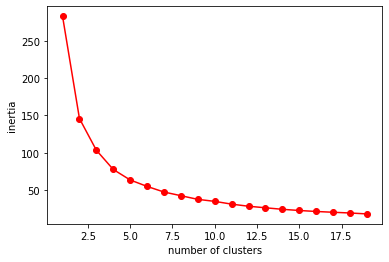

KMeans(n_clusters=5)

In [18]:
inertia_list = []
for k in np.arange(1, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans = kmeans.fit(scaled_df)
    inertia_list.append(kmeans.inertia_)
    
plt.plot(np.arange(1,20), inertia_list, 'ro-')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.show()

kmeans = KMeans(n_clusters=5)
kmeans.fit(scaled_df)

Assigning the predicted values into `labels` and print it out.

In [19]:
labels = kmeans.predict(scaled_df)
labels

array([3, 3, 3, 0, 1, 2, 3, 2, 0, 3, 2, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 0,
       2, 0, 3, 1, 0, 2, 3, 3, 3, 2, 1, 3, 1, 3, 1, 3, 0, 1, 0, 3, 3, 2,
       0, 0, 0, 2, 3, 0, 2, 1, 3, 1, 1, 2, 0, 0, 3, 2, 1, 1, 2, 1, 0, 0,
       2, 0, 0, 3, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 2, 0, 2, 3, 1, 1, 3, 3, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 0,
       3, 2, 3, 2, 2, 3, 1, 1, 1, 1, 0, 0, 3, 0, 3, 1, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 2, 2, 0, 0, 1, 1, 0, 0, 1, 0, 3, 0, 2, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 0,
       1, 0, 0, 2, 4, 2, 0, 0, 2, 1, 2, 2, 0, 2, 0, 1, 3, 2, 4, 2, 2, 2,
       1, 2, 2, 4, 0, 2, 4, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 2, 4, 2, 0, 0, 0, 2, 3, 2, 1, 3, 0, 0,
       2, 2, 0, 0, 0, 2, 3, 1, 2, 0, 4, 4, 0, 2, 0, 3, 0, 1, 2, 1, 0, 2,
       2, 4, 2, 4, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 4, 0, 4, 0, 0, 1, 1, 1,
       1, 2, 4, 4, 4, 2, 4, 4, 4, 4, 4, 4, 4, 0, 4,

### Plotting the Results
Scatter plot of <b>Volume of Blood Donated in C.C.</b> vs. <b>Time Since Last Donation</b>.

Text(0, 0.5, 'Time Since Last Donatioin')

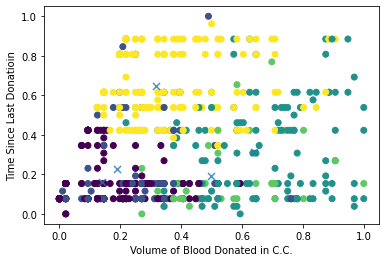

In [20]:
xs = scaled_df[:,3]
ys = scaled_df[:,0]
centroids = kmeans.cluster_centers_
plt.scatter(xs, ys, c=labels)
plt.scatter(centroids[:,3], centroids[:,0], marker='x', s=50, alpha=0.8, )
plt.xlabel("Volume of Blood Donated in C.C.")
plt.ylabel("Time Since Last Donatioin")

Scatter plot of <b>Volume of Blood Donated in C.C.</b> vs. <b>Number of Times Donated</b>.

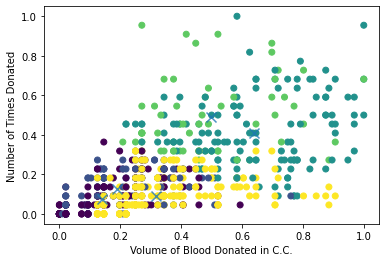

In [21]:
xs = scaled_df[:,3]
ys = scaled_df[:,1]
centroids = kmeans.cluster_centers_
plt.scatter(xs, ys, c=labels)
plt.scatter(centroids[:,3], centroids[:,1], marker='x', s=100, alpha=0.8)
plt.xlabel("Volume of Blood Donated in C.C.")
plt.ylabel("Number of Times Donated")
plt.show()

Scatter plot of <b>Volume of Blood Donated in C.C.</b> vs. <b>Time Since First Donation</b>.

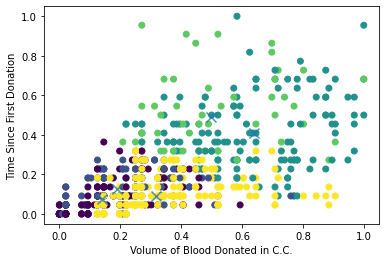

In [22]:
xs = scaled_df[:,3]
ys = scaled_df[:,2]


centroids = kmeans.cluster_centers_
plt.scatter(xs, ys, c=labels)
plt.scatter(centroids[:,3], centroids[:,2], marker='x', s=100, alpha=0.8)
plt.xlabel("Volume of Blood Donated in C.C.")
plt.ylabel("Time Since First Donation")
plt.show()

Showing the result with `calssification_report`.

In [23]:
print(classification_report(scaled_df[:,4], labels))

              precision    recall  f1-score   support

         0.0       1.00      0.35      0.51       558
         1.0       1.00      0.65      0.79       171
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0

    accuracy                           0.42       729
   macro avg       0.40      0.20      0.26       729
weighted avg       1.00      0.42      0.58       729



# Logistic Regression

#### Creating all the neccessary object and scaling of data
* First we seperate the feature data and target data into `X` and `y`
* `train_test_split()` to split the data into `x_train`, `x_test`, `y_train`, `y_test` so that the result are more accurate
* Scale the data using `StandardScaler()` based on the training data only, to prevent contamination of test data on train data
* Define a function `generate_scores()` to receive fitted model and test data and return accuracy, precision, recall, f1 score, and the confusion matrix

In [24]:
# LogisticRegression object
lr = LogisticRegression()

# Load target data into y
y = df['donate']

# Load features data into X
X = df[['last_donate','frequency','blood_cc','first_donate','rate']]

# train-test splitting the data for a more accurate comparison of before and after hyperparameter tuning.
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=39)

# Scale the data using StandardScaler, scale based on the training data
stdsc = StandardScaler()
stdsc.fit_transform(x_train)
stdsc.transform(x_test)

x_train.head(5)

,last_donate,frequency,blood_cc,first_donate,rate
611,4,1,250,4,0.000000
561,4,9,2250,52,5.333333
337,11,7,1750,64,7.571429
302,14,2,500,14,0.000000
643,10,5,1250,38,5.600000


In [35]:
def generate_scores(model, x_test, y_test):
    y_pred = model.predict(x_test)
    score_list = {}
    score_list['Accuracy'] = accuracy_score(y_test, y_pred)
    score_list['Precision'] = precision_score(y_test, y_pred, average='macro')
    score_list['Recall'] = recall_score(y_test, y_pred, average='macro')
    score_list['f1'] = f1_score(y_test, y_pred, average='macro')
    score_list['Confusion Matrix'] = confusion_matrix(y_test, y_pred)
    return score_list

### Before hyperparameter tuning
---
We just apply the logistic regression model onto the data without any hyperparameter tuning
We get a base score of

In [36]:
# fitting the model to the data.
logReg = lr.fit(x_train, y_train)

# Generate scores of the model
scores_default = generate_scores(logReg, x_test, y_test)
scores_default

{'Accuracy': 0.78,
 'Precision': 0.8166833166833167,
 'Recall': 0.574483082706767,
 'f1': 0.5686274509803922,
 'Confusion Matrix': array([[111,   1],
        [ 32,   6]], dtype=int64)}

### After hyperparameter tuning
---
#### param_grid
We create a dictionary of all possible parameters of logistic and name it as param_grid. This is to be inserted in GridSearchCV for finding the best combination of hyperparameters of the model.

In [37]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 30),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000, 2500, 5000]
    }
]

### GridSearchCV

We use GridSearchCV to loop through all possible combination of the  hyperparameters and perform a 5-fold cross validition on each combination. `n_job` is set to -1 to use all available processor to make the process faster. Since it is running through all the 2400 candidates for `cv`=5 times, it will take quite a while.

In [38]:
gscv = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [39]:
best_model = gscv.fit(x_train,y_train)

Fitting 5 folds for each of 2400 candidates, totalling 12000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 1154 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done 2136 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 3448 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 5012 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 6840 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 9048 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 11903 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 12000 out of 12000 | elapsed:  3.2min finished


In [40]:
best_model.best_estimator_  # to know the best model

LogisticRegression(C=0.0003562247890262444, max_iter=5000, solver='sag')

In [41]:
# fitting the model to the data.
default_lr = LogisticRegression().fit(x_train, y_train)

# Generate scores of the default model on test data
scores_default = pd.DataFrame(list(generate_scores(default_lr, x_test, y_test).items()), columns=['Type','Score'])
print('Default Model\n',scores_default)

# Generate scores of the best model
# train data
scores_tbest = pd.DataFrame(list(generate_scores(best_model, x_train, y_train).items()), columns=['Type','Score'])
print('Best Model on train data\n',scores_tbest)
# test data
scores_best = pd.DataFrame(list(generate_scores(best_model, x_test, y_test).items()), columns=['Type','Score'])
print('Best Model on test data\n',scores_best)

Default Model
                Type                Score
0          Accuracy                 0.78
1         Precision             0.816683
2            Recall             0.574483
3                f1             0.568627
4  Confusion Matrix  [[111, 1], [32, 6]]
Best Model on train data
                Type                   Score
0          Accuracy                 0.77592
1         Precision                0.695677
2            Recall                0.548706
3                f1                0.536015
4  Confusion Matrix  [[447, 11], [123, 17]]
Best Model on test data
                Type                Score
0          Accuracy             0.773333
1         Precision             0.739286
2            Recall             0.578712
3                f1             0.578373
4  Confusion Matrix  [[109, 3], [31, 7]]


# Ensemble Learning
---
this part we use bagging and boosting method to further improve the logistic regression model

In [42]:
# Importing the ensemble learning libraries
from sklearn. ensemble import BaggingClassifier, AdaBoostClassifier

## Bagging Classifier
---
#### param_grid
We create a dictionary of all possible parameters of logistic and name it as param_grid. This is to be inserted in `GridSearchCV` for finding the best combination of hyperparameters of the model.

In [43]:
param_grid = [
    {
    'n_estimators' : (np.arange(15)+1)*2,
    'max_samples' : (np.arange(10)+1)*0.1,
    'max_features' : (np.arange(10)+1)*0.1,
    }
]

### GridSearchCV

We use GridSearchCV to loop through all possible combination of the  hyperparameters and perform a 5-fold cross validition on each combination. `n_job` is set to -1 to use all available processor to make the process faster. Since it is running through all the 1500 candidates for `cv`=5 times, it will take quite a while.

In [44]:
gscv_bg = GridSearchCV(BaggingClassifier(LogisticRegression()),
                    param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [45]:
best_model_bg = gscv_bg.fit(x_train,y_train)

Fitting 5 folds for each of 1500 candidates, totalling 7500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 714 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 1064 tasks      | elapsed:   35.4s
[Parallel(n_jobs=-1)]: Done 1514 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done 2064 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2714 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3464 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 4314 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 5264 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 6314 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 7464 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 7500 out of 7500 | elapsed:  8.0min finished


In [46]:
best_model_bg.best_estimator_

BaggingClassifier(base_estimator=LogisticRegression(), max_features=0.8,
                  max_samples=0.1, n_estimators=14)

In [47]:
# fitting the model to the data.
default_lr = LogisticRegression().fit(x_train, y_train)

#Generate scores of the model
scores_default = pd.DataFrame(list(generate_scores(default_lr, x_test, y_test).items()), columns=['Type','Score'])
print('Default Model\n',scores_default)

# Generate scores of the best model
# train data
scores_tbest_bg = pd.DataFrame(list(generate_scores(best_model_bg, x_train, y_train).items()), columns=['Type','Score'])
print('Best Model on train data\n',scores_tbest_bg)
# test data
scores_best_bg = pd.DataFrame(list(generate_scores(best_model_bg, x_test, y_test).items()), columns=['Type','Score'])
print('Best Model on test data\n',scores_best_bg)

Default Model
                Type                Score
0          Accuracy                 0.78
1         Precision             0.816683
2            Recall             0.574483
3                f1             0.568627
4  Confusion Matrix  [[111, 1], [32, 6]]
Best Model on train data
                Type                   Score
0          Accuracy                0.769231
1         Precision                0.656968
2            Recall                0.544339
3                f1                0.531454
4  Confusion Matrix  [[443, 15], [123, 17]]
Best Model on test data
                Type                Score
0          Accuracy                 0.78
1         Precision              0.77896
2            Recall             0.583177
3                f1             0.583719
4  Confusion Matrix  [[110, 2], [31, 7]]


## AdaBoost Classifier
---
#### param_grid
We create a dictionary of all possible parameters of logistic and name it as param_grid. This is to be inserted in `GridSearchCV` for finding the best combination of hyperparameters of the model.

In [48]:
param_grid = [
    {
    'n_estimators' : (np.arange(15)+1)*2,
    'learning_rate' : (np.arange(10)+1)*0.1,
    }
]

### GridSearchCV

We use GridSearchCV to loop through all possible combination of the  hyperparameters and perform a 5-fold cross validition on each combination. `n_job` is set to -1 to use all available processor to make the process faster. Since it is running through all the 150 candidates for `cv`=5 times, it will take quite a while.

In [49]:
gscv_adb = GridSearchCV(AdaBoostClassifier(LogisticRegression()),
                    param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

In [50]:
best_model_adb = gscv_adb.fit(x_train,y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 482 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   37.1s finished


In [51]:
best_model_adb.best_estimator_

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=0.1,
                   n_estimators=8)

In [52]:
# fitting the model to the data.
default_lr = LogisticRegression().fit(x_train, y_train)

# Generate scores of the default model
scores_default = pd.DataFrame(list(generate_scores(default_lr, x_test, y_test).items()), columns=['Type','Score'])
print('Default Model\n',scores_default)

# Generate scores of the best model
# train data
scores_tbest_adb = pd.DataFrame(list(generate_scores(best_model_adb, x_train, y_train).items()), columns=['Type','Score'])
print('Best Model on train data\n',scores_tbest_adb)
# test data
scores_best_adb = pd.DataFrame(list(generate_scores(best_model_adb, x_test, y_test).items()), columns=['Type','Score'])
print('Best Model on test data\n',scores_best_adb)

Default Model
                Type                Score
0          Accuracy                 0.78
1         Precision             0.816683
2            Recall             0.574483
3                f1             0.568627
4  Confusion Matrix  [[111, 1], [32, 6]]
Best Model on train data
                Type                  Score
0          Accuracy               0.770903
1         Precision               0.678075
2            Recall               0.530552
3                f1               0.503126
4  Confusion Matrix  [[450, 8], [129, 11]]
Best Model on test data
                Type                Score
0          Accuracy             0.786667
1         Precision             0.888889
2            Recall             0.578947
3                f1             0.573864
4  Confusion Matrix  [[112, 0], [32, 6]]


In [53]:
# Print the scores for default model, and best model of Bagging and AdaBoost
print('Default Model\n',scores_default)
print('Best Model\n',scores_best_bg)
print('Best Model\n',scores_best_adb)

Default Model
                Type                Score
0          Accuracy                 0.78
1         Precision             0.816683
2            Recall             0.574483
3                f1             0.568627
4  Confusion Matrix  [[111, 1], [32, 6]]
Best Model
                Type                Score
0          Accuracy                 0.78
1         Precision              0.77896
2            Recall             0.583177
3                f1             0.583719
4  Confusion Matrix  [[110, 2], [31, 7]]
Best Model
                Type                Score
0          Accuracy             0.786667
1         Precision             0.888889
2            Recall             0.578947
3                f1             0.573864
4  Confusion Matrix  [[112, 0], [32, 6]]


## Decision Tree
----

<h4> Function </h4>

* `DecisionTreeClassifier` is a classification model for the decision tree, it able to handle regression and categorization data.
* `predict` predict the outcome of x test sample set
* `plot_tree` is decision tree visualization graph
* `fit` fit model by given the X train and Y train
* `accuracy_score` provides accurancy percentage of the training model.
* `cross_val()` create def function to return cross validation k-fold calculation of the model accuracy
* `confusion_ma` create function to return confusion matrix and the visualization graph.

<h4> Hyper parameter tuning </h4>

* `criterion` included {'gini', 'entropy'}. decision classifier support machine learning model by default gini index or choosing entropy information gain algorithm.
* `splitter` choose the best fit in the model
* `min_samples_split` minimum number to be split to internal node
* `min_samples_leaf` set the minimum number of samples that required to be the leaf node
* `max_features` maximum features is 4
* `min_impurity_decrease` a node will be split by decreaseing the impurity level, thus, we default = 0

* `node_ids` shows node id number
* `feature_names` show feature name of the data set
* `class_names` show the target value either donate or non-donate
* `filled` purity of the node for nultiple output
* `rounded` box rounded corners

<h4> Training of data </h4>

* `train_test_split` function to split data from feature and target to ratio 70:30 with random state splitting strategy.

In [54]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(xx1, yy1, test_size=0.3,random_state=90) 

# Cross Validation 
----

* `cross_val_score` is a function that use for resampling the data sample without any training or testing on the model. it use to estimate how well the model perform prediction with the accuracy.
* `cv` is stratified sample in K-fold splitting strategy

# Confusion matrix
----

* `confusion_matrix` perform confusion matrix to evaluate the accuracy of classification model. Required y_true and y_pred parameters.
* `annot`show boolean when annot is true for data value in each cell
* `fmt` is string formatting identical code that use for adding the annotations.
* `cmap` is matplotlib colormap
* `cubehelix_palette` is the function that procees the colormap with linearly decreasing or increasing the brightness level.

In [55]:
def confusion_ma(test_y,pred_y):

    cfm = confusion_matrix(test_y,pred_y)
    
    print('\n')
    #print('Confusion Matrix Plot')
    fig,ax = plt.subplots(figsize =(8,6))
    ax= sns.heatmap(cfm,
                  annot =True,
                  fmt="d",
                  cmap=sns.cubehelix_palette(6,start = 0.5,rot = -0.75),)
    plt.title('Confusion Matrix Plot')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.show()
    #plt.savefig('confusion_decision.png')

Accuracy for Decision Tree Model: 0.733333 

              precision    recall  f1-score   support

           0       0.85      0.80      0.83       178
           1       0.39      0.47      0.42        47

    accuracy                           0.73       225
   macro avg       0.62      0.64      0.62       225
weighted avg       0.75      0.73      0.74       225


Cross Validation for Decision Tree:  [0.5989304812834224, 0.7647058823529411, 0.7540106951871658, 0.8288770053475936]




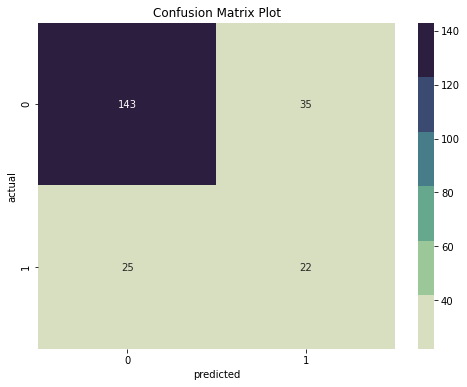

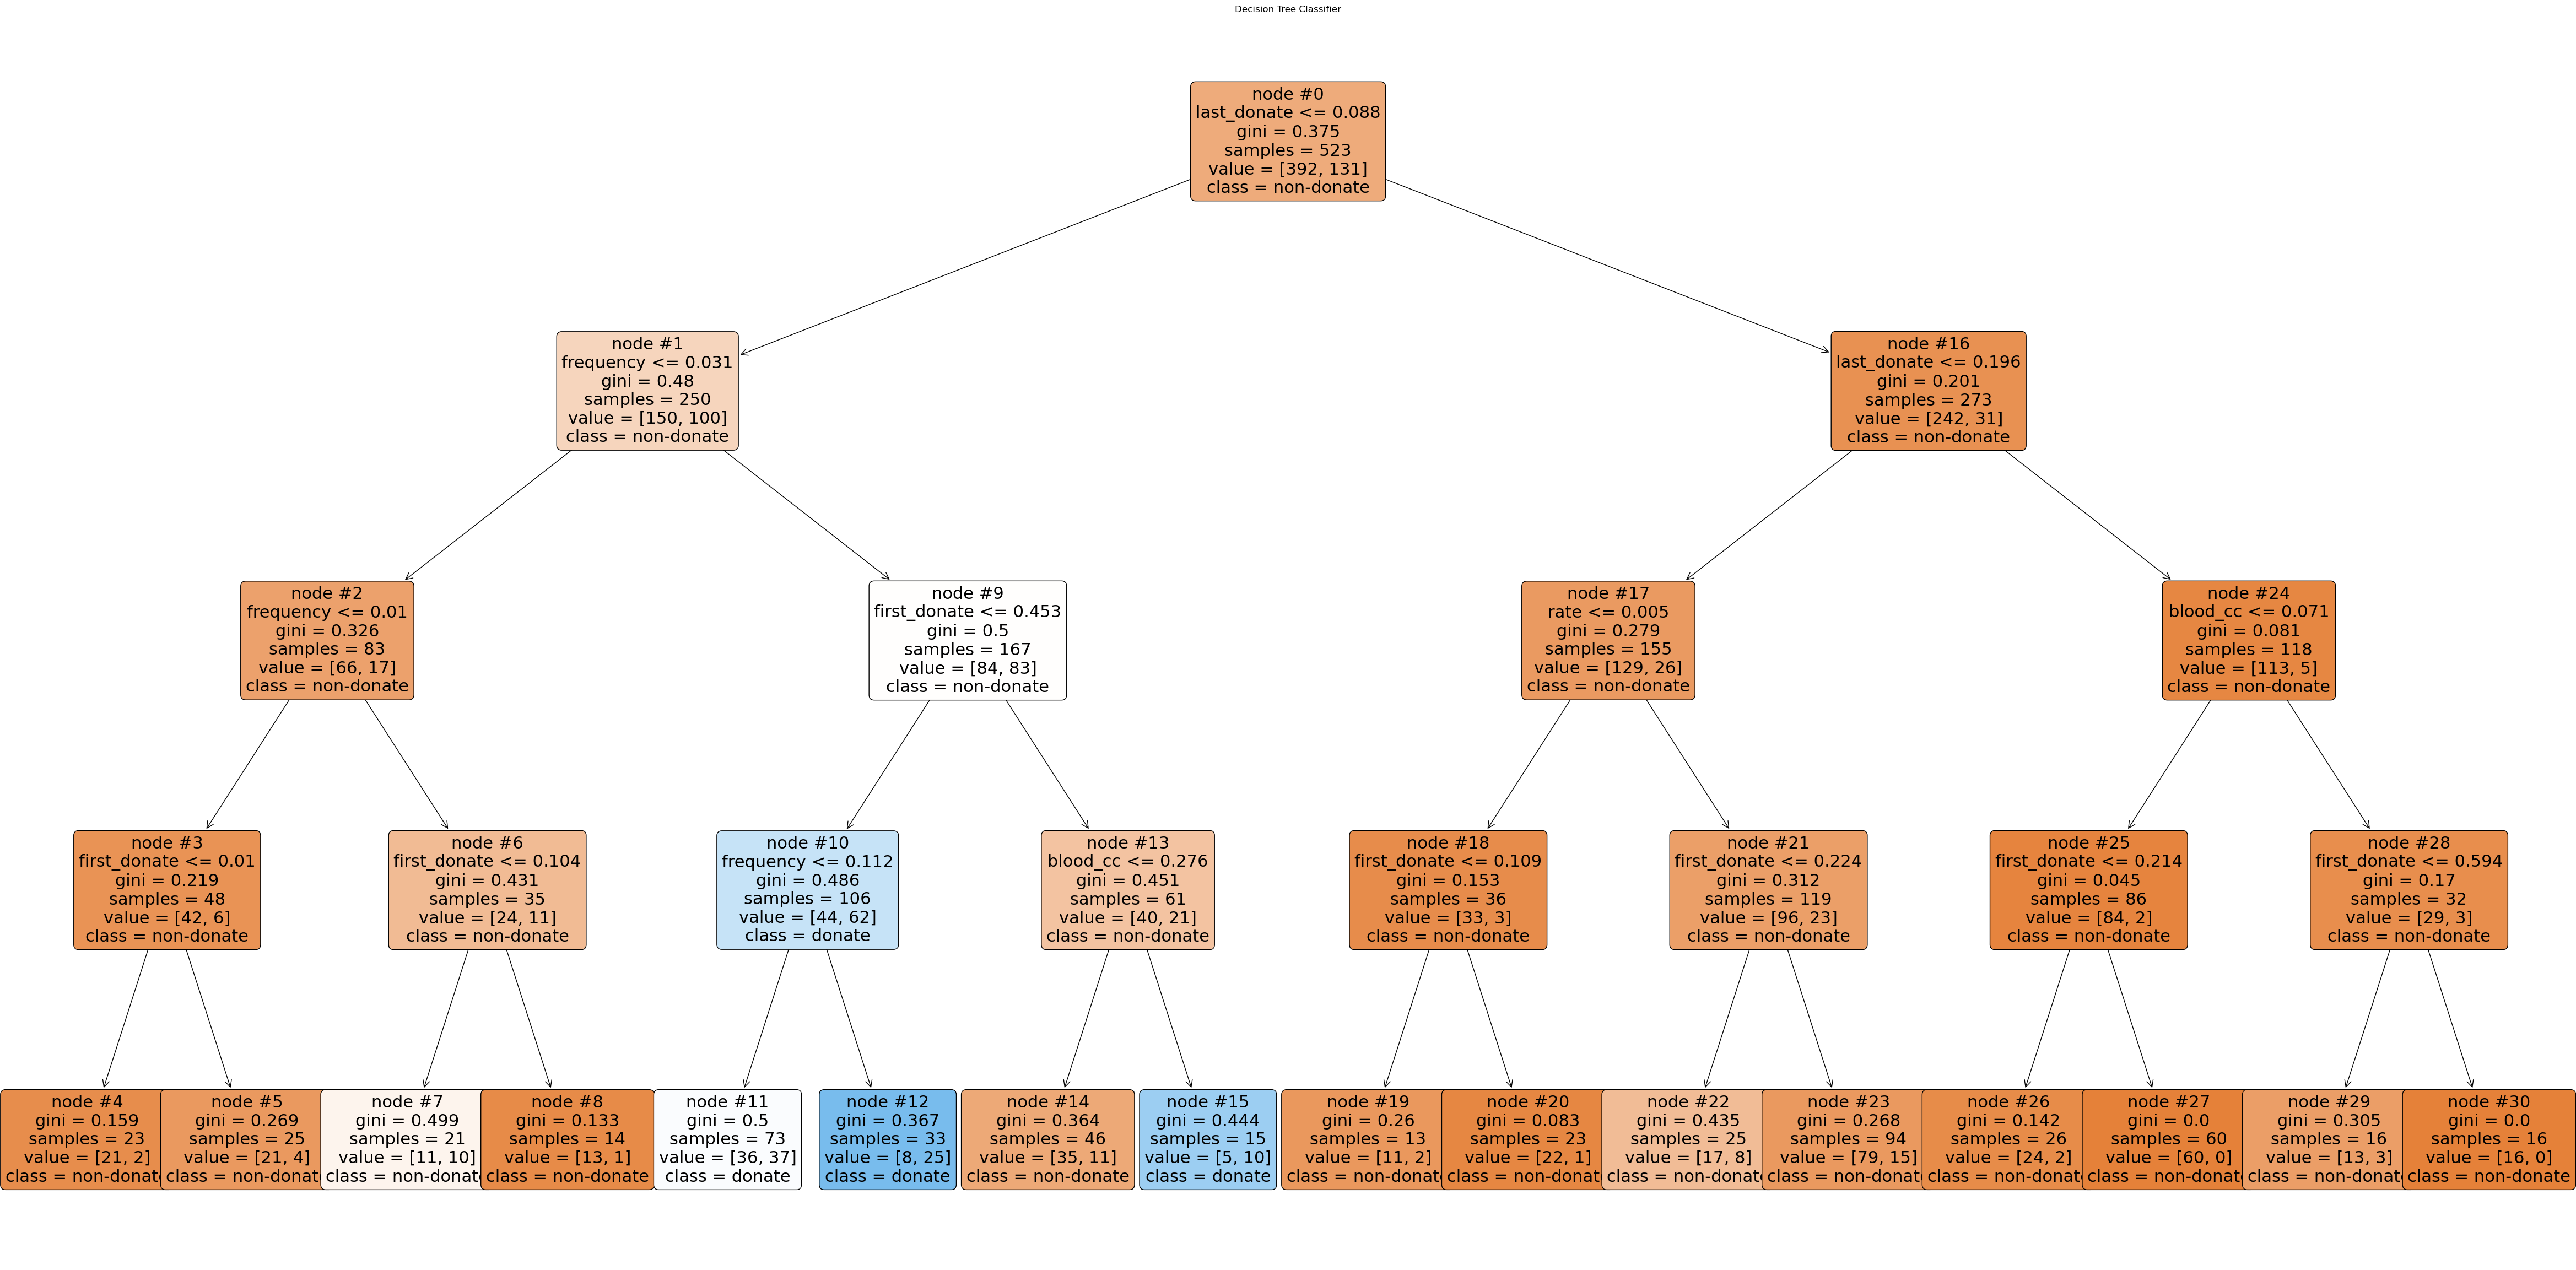

In [56]:
def decision_tree_nc(xtrain1,xtest1,ytrain1,ytest1):
   
    #decision tree model with 1 iteration
    clf1 = DecisionTreeClassifier(criterion="gini", max_depth=4,
                                  splitter='best',min_samples_split=2, 
                                  min_samples_leaf=2,max_features=4,
                                  random_state=70,
                                  min_impurity_decrease=0.0)

    # Train Decision Tree Classifer
    clf1 = clf1.fit(xtrain1,ytrain1)

    #Predict the response for test dataset
    ypred1 = clf1.predict(xtest1)

    # Model Accuracy
    score = accuracy_score(ytest1, ypred1)
    print("Accuracy for Decision Tree Model: %f" %score,'\n')
    
    #print classification report (recall, precision, accuracy, f1 score)
    print(metrics.classification_report(ytest1,ypred1))
    
    #cross validation
    cross_tree = cross_val_score(clf1,xx1,yy1,cv=4)
    print("\nCross Validation for Decision Tree: ", list(cross_tree))
    
    #confusion matrix call function
    confusion_ma(ytest1,ypred1)

    #plot decision classification model
    print('\n')
    plt.figure(figsize=(60,30), dpi = 100)  
    tree.plot_tree(clf1,label='all',
                   node_ids=True, 
                   feature_names = xx1.columns,
                   class_names=['non-donate', 'donate'], 
                   filled=True,fontsize=22,
                   rounded = True)
    plt.title('Decision Tree Classifier')
    #plt.savefig('decision_tree_gini.png')
    return score,cross_tree

tree_model_nc = decision_tree_nc(X_train1, X_test1, y_train1, y_test1)

## Randomized Search for Decision Tree
<h4> Decision Tree </h4>

* `RandomizedSearchCV` random search on hyperparameters
* `n_iter` set n iteration
* `best_params_` print best the hyperameters
* `best_score_` best mean score
* `cv` cross validation

In [57]:
#Randomized seacrch cv in the decision tree model
#either gini or entropy, best split or random split with diference depth length 
dtc = RandomizedSearchCV(DecisionTreeClassifier(),
                        {
                            'criterion' : ['gini','entropy'],
                            'splitter':['best','random'],
                            'max_depth':[2,4,6,8,10]
                        },

                        cv=4,
                        n_iter =10)
#fit model
rdm_dtc = dtc.fit(xx1,yy1)

#craete dataframe with view column
decision_rdm_cv = pd.DataFrame(rdm_dtc.cv_results_)[[
    'param_criterion','param_splitter','param_max_depth','mean_test_score','rank_test_score'
]]

print('The best parameter score: ', rdm_dtc.best_params_)
print('The best mean score: ', rdm_dtc.best_score_)
decision_rdm_cv

The best parameter score:  {'splitter': 'random', 'max_depth': 2, 'criterion': 'entropy'}
The best mean score:  0.7633689839572192


,param_criterion,param_splitter,param_max_depth,mean_test_score,rank_test_score
0,gini,best,4,0.715241,5
1,gini,random,8,0.699198,7
2,gini,random,10,0.679144,9
3,entropy,random,2,0.763369,1
4,entropy,best,4,0.736631,3
5,gini,best,2,0.681818,8
6,entropy,random,6,0.744652,2
7,entropy,best,6,0.701872,6
8,gini,best,8,0.647059,10
9,entropy,random,8,0.715241,4


# Random Forest
---
<h4> Function </h4>

* `RandomForestClassifier` is a classification model to improve the prediction of decision tree with various sub-samples which can avoid over-fitting problem of decision tree model.
* `fit` fit model by given the X train and Y train
* `predict` predict the outcome of x test sample set
* `accuracy_score` provides accurancy percentage of the training model.\
* `confusion_ma` create function to return confusion matrix and the visualization graph.

<h4> Hyper parameter tuning </h4>

* `criterion` included {'gini', 'entropy'}. Random Forest classifier support machine learning model by default gini index or choosing entropy information gain algorithm.
* `min_samples_split` minimum number to be split to internal node, by default is 2
* `min_samples_leaf` set the minimum number of samples that required to be the leaf node
* `max_features` feature of split in integer or float for looking the best split. By default is 'auto'
* `min_impurity_decrease` a node will be split by decreaseing the impurity level, thus, we default = 0

              precision    recall  f1-score   support

  non-donate       0.84      0.83      0.84       178
      donate       0.39      0.40      0.40        47

    accuracy                           0.74       225
   macro avg       0.61      0.62      0.62       225
weighted avg       0.75      0.74      0.74       225


Cross Validation for Random Forest:  [0.6737967914438503, 0.7593582887700535, 0.7647058823529411, 0.786096256684492]

 last_donate     0.334611
rate            0.235087
first_donate    0.149535
frequency       0.141967
blood_cc        0.138801
dtype: float64




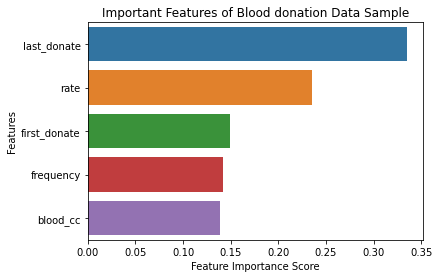

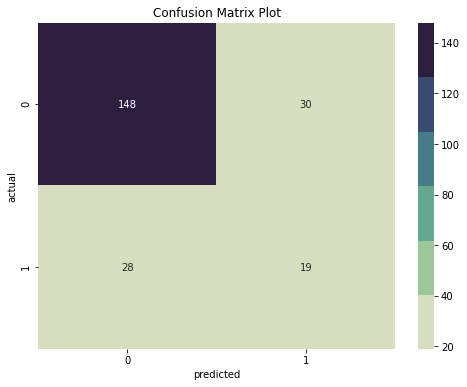

In [58]:
def random_forest(xtrain1,xtest1,ytrain1,ytest1):
   
    #Create a random forest Classifier {'gini' or 'entropy'}
    clf2 = RandomForestClassifier(n_estimators=300,criterion='gini',
                                  max_depth=4,
                                  min_samples_split=2, 
                                  min_samples_leaf=2,
                                  max_features='auto',
                                  random_state=200,
                                  min_impurity_decrease=0.0)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf2 = clf2.fit(xtrain1,ytrain1)

    y_pred1 = clf2.predict(xtest1)

    # Model Accuracy
    score = accuracy_score(ytest1, y_pred1)
    #print("Accuracy for Decision Tree Model: %f" %score)
   
    #print classification report
    print(classification_report(ytest1,y_pred1,target_names=['non-donate','donate']))

     #cross validation
    cross_tree = cross_val_score(clf2,xx1,yy1,cv=4)
    print("\nCross Validation for Random Forest: ", list(cross_tree))
    
    #important feature by calculating percentage 
    #and sort values largest to smallest
    feature_imp = pd.Series(clf2.feature_importances_
                            ,index=xx1.columns).sort_values(ascending=False)
    
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title("Important Features of Blood donation Data Sample")
    
    # Show in bar chart
    sns.barplot(feature_imp, y=feature_imp.index)
    print('\n',feature_imp)
    
    #confusion matrix

    confusion_ma(ytest1,y_pred1)
    
    #fig, axes = plt.subplots(figsize = (40,15), dpi=85)
    #tree.plot_tree(clf2.estimators_[0],
    #               label='all',
    #               node_ids=True,
    #               feature_names = xx1.columns,
    #               class_names=['non-donate','donate'],
    #               filled = True)
    #plt.savefig('random forest.png')
    plt.show()
    
    
    return score, cross_tree

randomforest_model = random_forest(X_train1, X_test1, y_train1, y_test1)

# Randomized Search for Random Forest
<h4> Random Forest </h4>

* `RandomizedSearchCV` random search on hyperparameters
* `n_iter` set n iteration
* `n_estimators` number of tree in the forest
* `best_params_` print best the hyperameters
* `best_score_` best mean score
* `cv` cross validation

In [59]:
#randomized search cv for random forest
# with different number of sub-tree and depth length in the forest
dtc2 = RandomizedSearchCV(RandomForestClassifier(),
                        {
                            'n_estimators':[100,150,200,250,300],
                            'max_depth':[2,4,6,8,10,12,14]
                        },
                         
                        cv=4,
                        n_iter =10)

#fit model
rdm_rdmf = dtc2.fit(xx1,yy1)

#craete dataframe with view column
random_forest_rdm_cv = pd.DataFrame(rdm_rdmf.cv_results_)[[
    'param_n_estimators','param_max_depth','mean_test_score','rank_test_score'
]]

print('The best parameter score: ', rdm_rdmf.best_params_)
print('The best mean score: ', rdm_rdmf.best_score_)

random_forest_rdm_cv

The best parameter score:  {'n_estimators': 100, 'max_depth': 2}
The best mean score:  0.7633689839572192


,param_n_estimators,param_max_depth,mean_test_score,rank_test_score
0,150,10,0.708556,6
1,300,8,0.716578,5
2,200,14,0.701872,8
3,150,12,0.689840,10
4,200,4,0.741979,3
5,100,2,0.763369,1
6,150,4,0.737968,4
7,300,2,0.763369,1
8,150,14,0.697861,9
9,100,8,0.707219,7


## Evaluate Of Decision Tree and Random Forest with Random Search CV

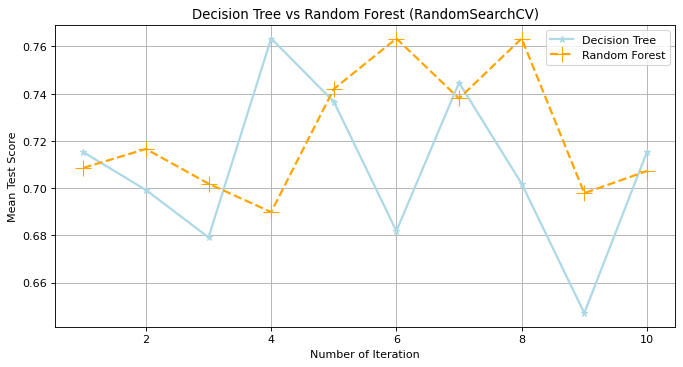

In [60]:
iteration = list(range(1,11))
fig,ax1=plt.subplots(figsize=(10,5),dpi=80)
plt.plot(iteration, decision_rdm_cv.iloc[:,3], ls='-',lw=2,marker = '*',c='lightblue')
plt.plot(iteration, random_forest_rdm_cv.iloc[:,2], ls='--',lw=2,marker = '+', c='orange',markersize=15)
plt.grid()
plt.xlabel('Number of Iteration')
plt.ylabel('Mean Test Score')
plt.legend(['Decision Tree','Random Forest'],loc='best')
plt.title('Decision Tree vs Random Forest (RandomSearchCV)')
plt.show()

# Support Vector Machine
---

Since we only deal with linearly separable and two-class is used for visualization: 
- `first_donate`
- `frequency` 
- and the target `donate`

In [61]:
# Dataframe df_svm with 2 features 1 target
df_svm = df_norm[['frequency','first_donate','donate']]
x = df_svm[['frequency','first_donate']].values
y = df_svm[['donate']].values

Scatterplot for visualization between features, `frequency` and `first_donate` based on their respective target, `donate`.

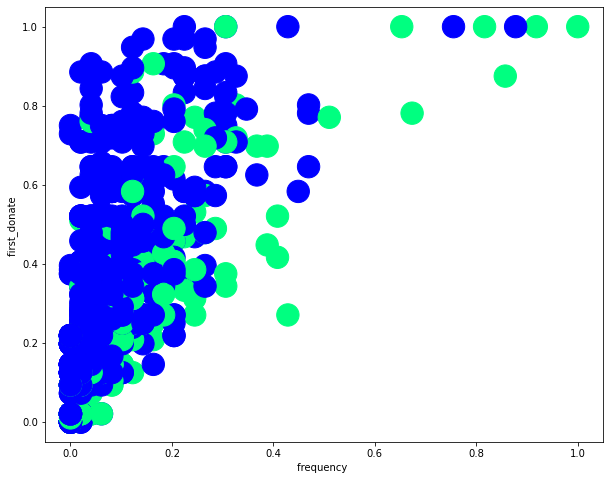

In [62]:
plt.figure(figsize = (10,8))
plt.scatter(x[:,0], x[:,1], c=y, s=500, cmap='winter')
plt.xlabel('frequency ')
plt.ylabel('first_donate ')
plt.show()

Then we split the data into training data and test data for further prediction later.

In [63]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 90)

In [64]:
clf = SVC(kernel='rbf', C = 100, gamma = .5).fit(x_train, y_train)
y_pred = clf.predict(x_test)

In [65]:
cross_val_score(clf, x, y, cv=5)

array([0.77333333, 0.76      , 0.75333333, 0.77181208, 0.76510067])

In [66]:
print("Rbf Kernel SVM:\n" + classification_report(y_test, y_pred))

Rbf Kernel SVM:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89       178
           1       0.67      0.04      0.08        47

    accuracy                           0.80       225
   macro avg       0.73      0.52      0.48       225
weighted avg       0.77      0.80      0.72       225



(-0.05, 1.05)

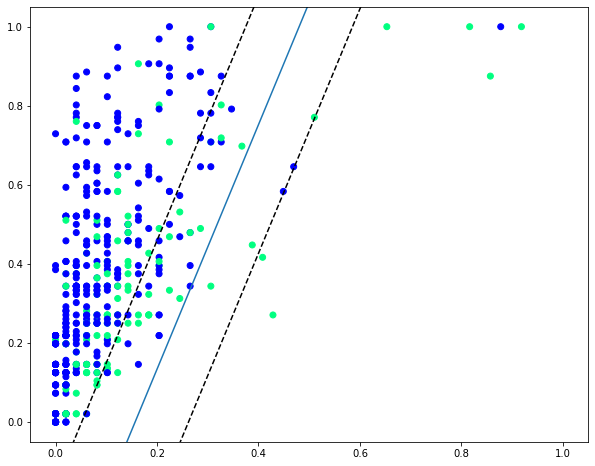

In [67]:
# Manually Linear Kernel
svc = LinearSVC()
svc.fit(x_train, y_train)

plt.figure(figsize = (10, 8))
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, cmap='winter');

ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]

xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)

yy = a * xx - (svc.intercept_[0] - 0.3) / w[1]
plt.plot(xx, yy, 'k--')

yy = a * xx - (svc.intercept_[0] + 0.3) / w[1]
plt.plot(xx, yy, 'k--')

ax.set_xlim([-0.05,1.05])
ax.set_ylim([-0.05,1.05])

Now we can see that, the 'linear' kernel is not working. It tries to use a linear boundary to classify the data,  which is impossible. We will be using a different kernel to transform this data into higher dimensions to separate them.

In [68]:
def plot_desicion_boundary(x, y, clf, title = None):
    
    x_min, x_max = x[:, 0].min()-.05, x[:, 0].max()+.2
    y_min, y_max = x[:, 1].min()-.05, x[:, 1].max()+.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                         np.arange(y_min, y_max, .1))

    z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    z = z.reshape(xx.shape)
    
    plt.figure(figsize = (10, 8))
    plt.contourf(xx, yy, z, alpha=0.4)
    plt.scatter(x[:, 0], x[:, 1], c=y, alpha=0.8, cmap='winter')
    
    if title is not None:
        plt.title(title)
    
    # highlight the support vectors
    plt.xlabel('frequency')
    plt.ylabel('first_donate')
    plt.show()

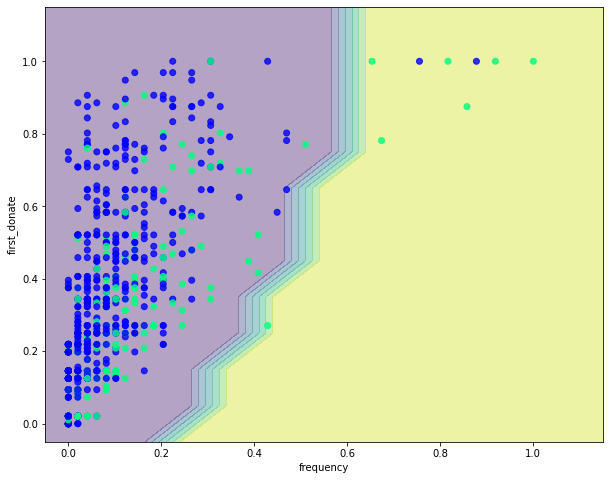

In [69]:
plot_desicion_boundary(x, y, clf)

In [70]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    fig = plt.figure(figsize=(10, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.tight_layout()
    plt.ylabel('True value')
    plt.xlabel('Predicted value')
    plt.show()

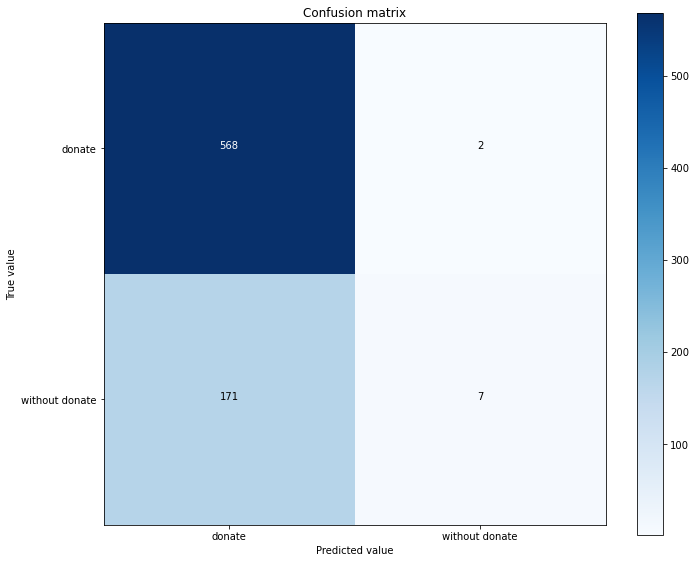

In [74]:
# Confusion matrix
predicted_rbf = clf.predict(x)
cm = confusion_matrix(y, predicted_rbf)
plot_confusion_matrix(cm, classes=['donate','without donate'],
                      title='Confusion matrix')

After we used the 'rbf' kernel, it seems the SVM still classify them effectively. Even though, 'rbf' kernel based SVM looks much flexible, but it is still overfit the data. 

---

The C and gamma parameter in the SVM are the most important parameters for the 'rbf' kernel, that can be determined by the grid-search method.
But we need get a sense how they affect the results if we change them. 

- Larger C, lower bias, higher variance. 
- Smaller C, higher bias, lower variance. 

The following 3 figures showing different values of C, that is, C = 1, C = 100, C = 10000. We can see the higher the value C,  the more complicated the decision boundary is, which tries to fit every training data, even with some clearly anomaly data. 

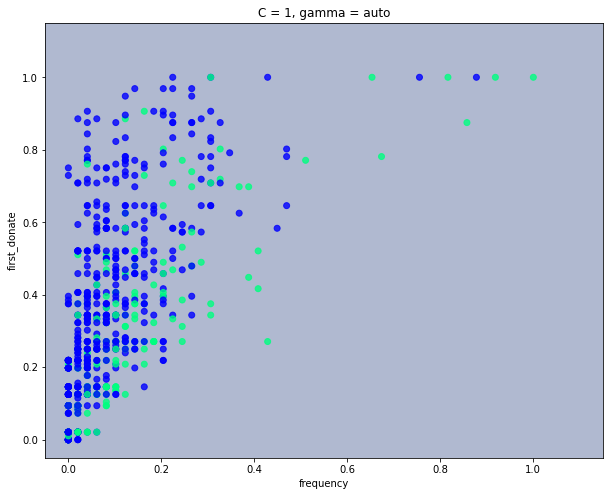

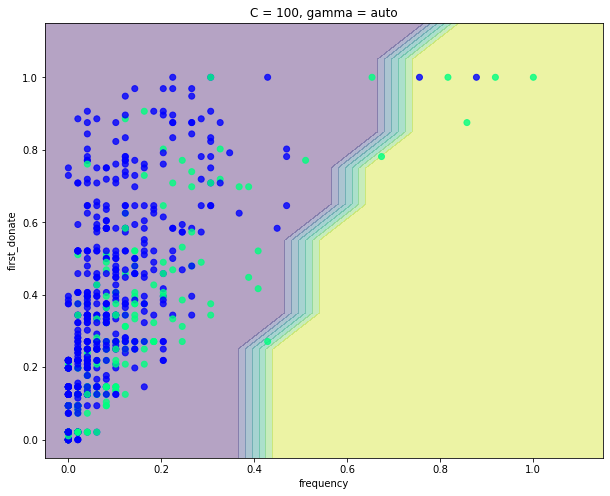

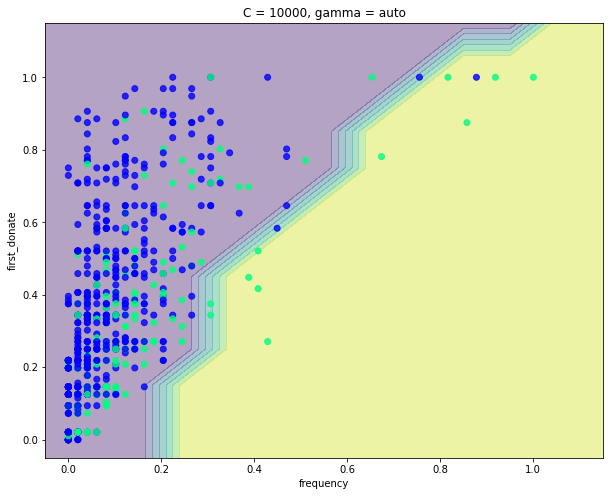

In [75]:
# C = 1
clf = svm.SVC(kernel='rbf', C = 1, gamma = 'auto')
clf.fit(x,y)
plot_desicion_boundary(x, y, clf, title = 'C = 1, gamma = auto')

# C = 100
clf = svm.SVC(kernel='rbf', C = 100, gamma = 'auto')
clf.fit(x,y)
plot_desicion_boundary(x, y, clf, title = 'C = 100, gamma = auto')

# C = 10000
clf = svm.SVC(kernel='rbf', C = 10000, gamma = 'auto')
clf.fit(x,y)
plot_desicion_boundary(x, y, clf, title = 'C = 10000, gamma = auto')

# Hierarchical Clustering
---

We will be using the original dataset.

In [76]:
# Default dataframe
df_hie = df_norm[['last_donate','frequency','blood_cc','first_donate','donate']]

## Dendrogram

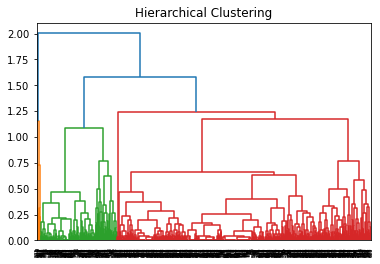

In [77]:
mergings = shc.linkage(df_hie, method="complete", metric='euclidean')
shc.dendrogram(mergings)
plt.title('Hierarchical Clustering') 

plt.show()

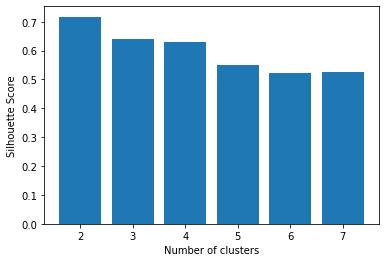

In [80]:
# Find the suitable cluster k
pca = PCA(n_components=2)
X_principal = pca.fit_transform(df_hie)
X_principal = pd.DataFrame(X_principal)
X_principal.columns = ['P1', 'P2'] 

silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Here the highest silhouette coefficient is for k=2, so we would select 2 clusters, where we have 2 set of target in our data.

In [81]:
# Cutting the Dendrogram with 2 clusters
cluster_labels = shc.cut_tree(mergings, n_clusters=2).reshape(-1, )

df_hie['Cluster_Labels'] = cluster_labels
df_hie.head()

,last_donate,frequency,blood_cc,first_donate,donate,Cluster_Labels
0,0.027027,1.000000,1.000000,1.000000,1,0
1,0.000000,0.244898,0.244898,0.270833,1,1
2,0.013514,0.306122,0.306122,0.343750,1,1
3,0.027027,0.387755,0.387755,0.447917,1,1
4,0.013514,0.469388,0.469388,0.781250,0,1


We have boxplot for `frequency` and `first_donate` against the `Cluster_Labels`.

<AxesSubplot:xlabel='Cluster_Labels', ylabel='frequency'>

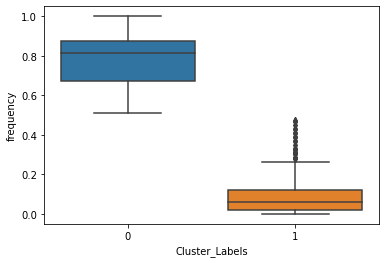

In [82]:
sns.boxplot(x='Cluster_Labels', y='frequency', data=df_hie)

<AxesSubplot:xlabel='Cluster_Labels', ylabel='first_donate'>

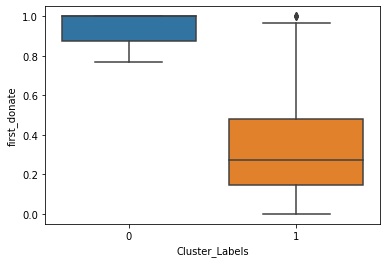

In [83]:
sns.boxplot(x='Cluster_Labels', y='first_donate', data=df_hie)